# Proyecto de ciencia de datos
### Caso de estudio: Precio de bienes inmueble en la Ciudad de Buenos Aires
#### *Tomás Gandolfo*
#### *Datos de Properati*

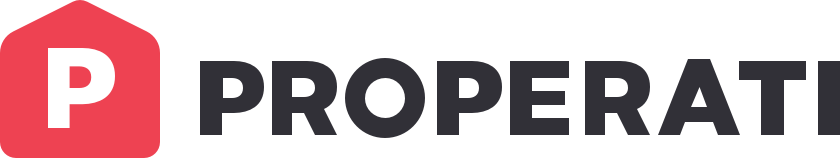

In [86]:
from IPython import display 
display.Image("https://d3oky698b3gnfy.cloudfront.net/assets/img/isologo-properati.png",width=500)

## comprensión comercial
Según la página oficial de la empresa:
>La **misión** de Properati es empoderar a nuestros usuarios para que tengan el mejor camino a su próxima casa, mediante herramientas tecnológicas y datos relevantes. En paralelo, buscamos ayudar a los vendedores a que sean más eficientes y brinden el mejor servicio posible a los potenciales compradores.

>**Visión**: Ser la plataforma de inmuebles más enfocada en el usuario del mundo, sin importar dónde se encuentre. Tenemos un horizonte global, pero también la versatilidad necesaria para satisfacer las necesidades locales.

Adicionalmente:
>*Quienes busquen un nuevo hogar o quieran invertir* en propiedades encontrarán en Properati, además de las ofertas disponibles, valiosa información para tomar las mejores decisiones: promedios de precios, características de los barrios, comparaciones, etc.
>Properati también ofrece una propuesta novedosa para las *inmobiliarias o agentes* que quieran vender una propiedad, ya que el modelo de negocios se basa en entregar contactos de calidad.

Vemos que Properati brinda servicio tanto a compradores como vendedores. Entre estos servicios está el proporcionar información valiosa y de calidad para facilitar una correcta toma de decisiones, incluyendo los precios. Por lo que comprender cuáles son los las variables que más influyen en éstos y a su vez poder estimar cuál sería el precio más probable o acorde para una determinada propiedad, es sin dudas valioso para los fines del negocio.

**El presente proyecto se propone los siguientes objetivos:**
* Determinar cuáles son las variables que determinan los precios.
* Desarrollar los modelos predictortes de los precios.

El **alcance del proyecto** comprende los bienes inmueble del tipo PH, casas y departamentos en la Ciudad Autónoma de Buenos Aires.

Los datos fueron obtenidos por la página oficial de Properati, pre-filtrados por Acámica.

En la determinación del precio de un inmueble, son fundamentales los datos sobre su localización (ubicación, zona y características de los alrededores), cercanía con zonas comerciales y transportes.

##Análisis Exploratorio de Datos

Se realizará un análisis Exploratorio de Datos sobre el dataset de propiedades de Properati, donde se buscará responder (entre otras) las siguientes preguntas:

* ¿Qué tamaño tiene el dataset?¿Cuántas instancias y cuántas columnas?
* ¿Cuántos valores faltantes hay en cada columna?
* ¿Cómo es la distribución de cada variable?
* ¿Cómo se relacionan las variables entre sí?
* ¿Cómo están correlacionadas las variables numéricas?¿Cuáles serán los mejores predictores de la variable de interés?

Ante cualquier duda del lector sobre el dataset que no sea satisfecha en el presente documento, puede consultar [aquí](https://www.properati.com.ar/data/). Algunas columnas fueron descartadas respecto del set de datos original de la página web.

Nota: [Gran Buenos Aires](https://es.wikipedia.org/wiki/Gran_Buenos_Aires) o AMBA es un conjunto de ciudades que rodean a la Ciudad Autónoma de Buenos Aires (CABA), Argentina.



Importación de las librerías necesarias.

In [2]:
# Librerías básicas para el manejo de datasets y ploteo de gráficos
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.interpolate import griddata

In [3]:
# Modelos
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from mlxtend.plotting import plot_decision_regions

In [4]:
# Evitar la visualización de warnings debido a funciones deprecadas de las librerías
import warnings
warnings.filterwarnings('ignore')

Carga el dataset (upload específico para Google Colab)

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Autenticación y creación del PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
downloaded = drive.CreateFile({'id':'tu id'}) 
downloaded.GetContentFile('DS_Proyecto_01_Datos_Properati.csv')  
properati_df = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
# Carga del dataset en un dataframe de pandas.

Tamaño del set de datos:

In [10]:
print("Cantidad de:")
print("  - filas: " + str(properati_df.shape[0]))
print("  - columnas: " + str(properati_df.shape[1]))

Cantidad de:
  - filas: 146660
  - columnas: 19


Visualización de las primeras filas:

In [11]:
properati_df.head(2)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta


Valores Faltantes por variable:

In [13]:
properati_df.isna().sum()

start_date             0
end_date               0
created_on             0
lat                 9925
lon                 9959
l1                     0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           5957
surface_total      20527
surface_covered    21614
price                  0
currency               0
title                  0
description            0
property_type          0
operation_type         0
dtype: int64

In [14]:
properati_df.columns

19

Se observa que el conjunto de datos posee 19 tipos de variable (una objetivo y 18 features) y que cinco de ellas cuentan con valores nulos, siendo las más significativas las de superficie total y superficie cubierta. Variables que probablemente sean las más influyentes en el precio total de una propiedad, junto con la ubicación.

Ahora evalúo cuántas de las filas tienen valores nulos en estas dos variables:

In [52]:
print((properati_df.surface_total.isna() | properati_df.surface_covered.isna()).sum())

22129


### **Tipos de propiedad**: 
Cantidad de tipos de propiedad publicados:

In [19]:
len(properati_df.property_type.value_counts())

10

Cantidad de publicaciones por cada tipo de propiedad:

In [ ]:
properati_df.property_type.value_counts()

Departamento       107326
Casa                21521
PH                  14298
Lote                 1312
Oficina               658
Otro                  374
Local comercial       325
Casa de campo         322
Depósito              265
Cochera               259
Name: property_type, dtype: int64

Porcentaje de cada tipo respecto del total:

In [16]:
(properati_df.property_type.value_counts()/(properati_df.property_type.value_counts().sum()))*100

Departamento       73.180145
Casa               14.674076
PH                  9.749080
Lote                0.894586
Oficina             0.448657
Otro                0.255012
Local comercial     0.221601
Casa de campo       0.219555
Depósito            0.180690
Cochera             0.176599
Name: property_type, dtype: float64

Porcentaje de las tres primeras respecto del total:

In [17]:
(properati_df.property_type.value_counts()[0:3].sum()/(properati_df.property_type.value_counts().sum()))*100

97.60330015000682

Visualización:

[Text(0.5, 0, 'Tipo de propiedad'), Text(0, 0.5, 'Cantidad')]

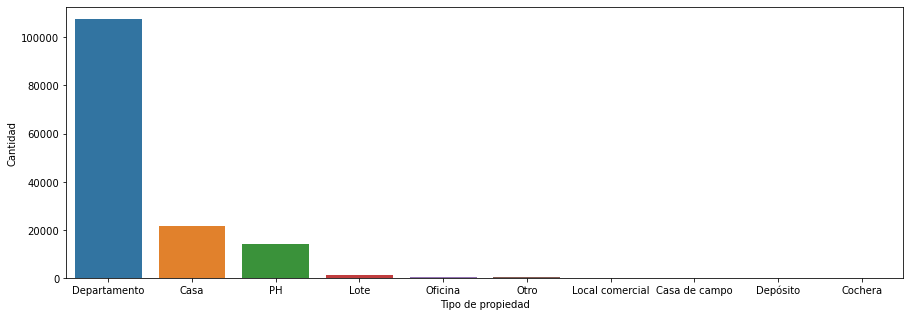

In [ ]:
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = properati_df.property_type.value_counts().index, y = properati_df.property_type.value_counts().values)
ax.set(xlabel="Tipo de propiedad", ylabel = "Cantidad")

Vemos que hay diez tipos de propiedad en el set de datos, siendo 'Departamento', 'Casa' y 'PH' las más significativas representando el **97.6%** del total.

### Ubicación de los inmuebles

Regiones presentes y cantidad de publicaciones en cada una:

In [ ]:
properati_df.l2.value_counts()

Capital Federal             92539
Bs.As. G.B.A. Zona Norte    24282
Bs.As. G.B.A. Zona Sur      17173
Bs.As. G.B.A. Zona Oeste    12666
Name: l2, dtype: int64

In [ ]:
print('CABA representa el '+str(round(properati_df.l2.value_counts()[0]*100/properati_df.l2.value_counts().sum(),2)) + '% del total de las publicaciones')

CABA representa el 63.1% del total de las publicaciones


Ciudades del AMBA y barrios de CABA presentes con sus respectivas cantidades de publicaciones:

In [ ]:
properati_df.l3.value_counts()

Palermo            13073
Tigre               8718
Almagro             7527
Belgrano            6935
Caballito           6650
                   ...  
Cañuelas             108
Villa Soldati         69
Villa Riachuelo       42
Marcos Paz            35
Catalinas              5
Name: l3, Length: 89, dtype: int64

Como la cantidad de regiones en l3 son demasiadas, para graficar selecciono el 70% con mayor cantidad de muestras.

Porcentaje mostrado de l3: 70.33%


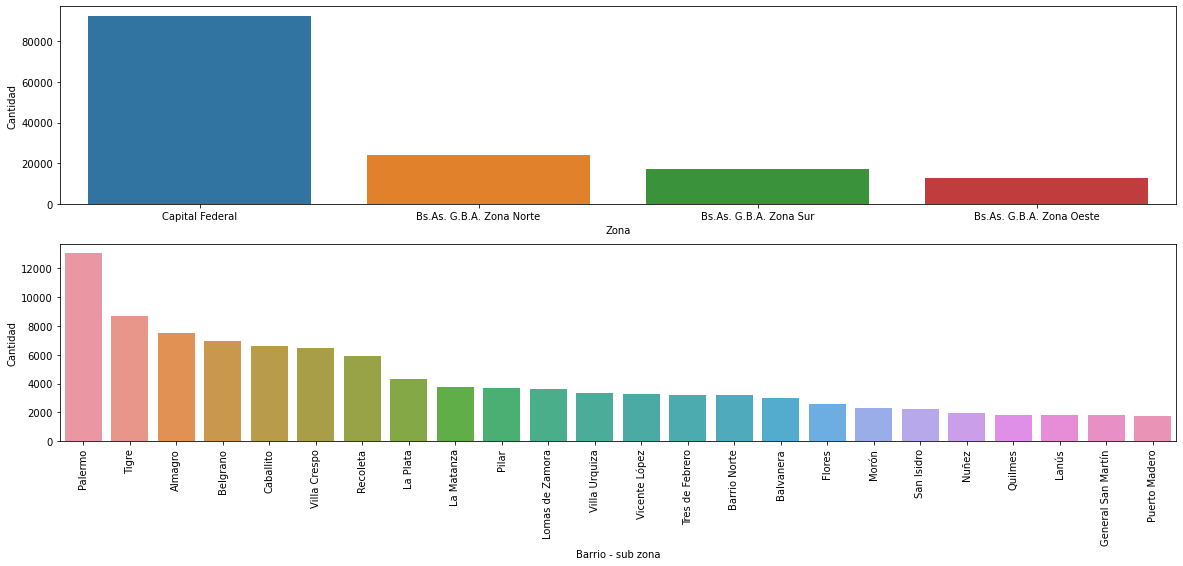

In [ ]:
size = properati_df.shape[0]
proporcion = 0
count = 0
i = 0
while (proporcion < 0.7):
    count = count + properati_df.l3.value_counts()[i]
    proporcion = count/size
    i += 1

print('Porcentaje mostrado de l3: ' + str(round(proporcion * 100, 2)) + '%')


fig, axs = plt.subplots(nrows= 2, ncols= 1,figsize=(20,8))
sns.barplot(x = properati_df.l2.value_counts().index, y = properati_df.l2.value_counts().values, ax=axs[0])
axs[0].set(xlabel="Zona", ylabel = "Cantidad")
sns.barplot(x = properati_df.l3.value_counts()[:i].index, y = properati_df.l3.value_counts()[:i].values, ax=axs[1]).set_xticklabels(axs[1].get_xticklabels(),rotation=90)
axs[1].set(xlabel="Barrio - sub zona", ylabel = "Cantidad")

plt.show()

Se obtiene que la mayor concentración de datos se encuentra en CABA, representando el 63.1% del total y teniendo algunos de sus barrios incluso más publicaciones que las ciudades más importantes del AMBA (fuera de CABA), como La Plata.

De estos barrios, Palermo, Almagro, Belgrano, Caballito, Villa Crespo y Recoleta son los más significativos.

###**Filtrado inicial del Dataset:** 
A partir de lo evaluado, seleccionaré las tres clases más abundantes de tipos de propiedad (PH, Casa y Departamento) y la región con más propiedades publicadas (CABA).

In [57]:
work_df = properati_df[(properati_df["l2"] == "Capital Federal") & ((properati_df["property_type"] == "Departamento") | (properati_df["property_type"] == "Casa") | (properati_df["property_type"] == "PH"))].copy()
work_df.shape

(91485, 19)

In [58]:
print('Cantidad de filas originales:',properati_df.shape[0],'\nCantidad de filas luego del filtrado:',work_df.shape[0],
      '\nPorcentaje conservado:',round(work_df.shape[0]/properati_df.shape[0],4)*100,'%')

Cantidad de filas originales: 146660 
Cantidad de filas luego del filtrado: 91485 
Porcentaje conservado: 62.38 %


### **Distribuciones y relaciones de a pares:** 

Estudiaré la distribución y las relaciones de a pares de las variables `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered`, `price` para cada tipo de propiedad.

Asimismo obtendré estadísticos que sirvan para tener una primera idea de los valores que abarcan estas variables.

In [59]:
work_df.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,86951.000000,86937.000000,91485.000000,91485.000000,89314.000000,82568.000000,82250.000000,9.148500e+04
mean,-34.599081,-58.436002,2.964278,1.960278,1.560147,112.626369,94.966310,2.595003e+05
std,0.023957,0.036297,1.314704,1.072946,0.860309,980.713664,778.515243,3.222654e+05
min,-34.696419,-58.530468,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,-34.613757,-58.459605,2.000000,1.000000,1.000000,49.000000,44.000000,1.200000e+05
50%,-34.599446,-58.433789,3.000000,2.000000,1.000000,71.000000,63.000000,1.750000e+05
75%,-34.584148,-58.410143,4.000000,3.000000,2.000000,111.000000,96.000000,2.790000e+05
max,-34.535818,-58.353930,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


Se observa que el desvío estándar de las variables de superficie es elevado, por lo que podría requerir tratamiento (es probable que posea valores atípicos que estén distorcionando los estadísticos).

Procedo a graficar diagramas de cajas para cada una de las variables.

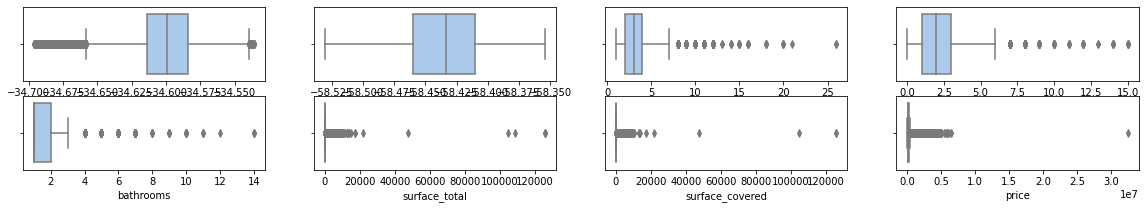

In [60]:
def outliers_boxplot (work_df):
    fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(20,3))
    sns.boxplot(work_df.lat, palette = 'pastel', ax = axs[0][0])
    sns.boxplot(work_df.lon, palette = 'pastel', ax = axs[0][1])
    sns.boxplot(work_df.rooms, palette = 'pastel', ax = axs[0][2])
    sns.boxplot(work_df.bedrooms, palette = 'pastel', ax = axs[0][3])
    sns.boxplot(work_df.bathrooms, palette = 'pastel', ax = axs[1][0])
    sns.boxplot(work_df.surface_total, palette = 'pastel', ax = axs[1][1])
    sns.boxplot(work_df.surface_covered, palette = 'pastel', ax = axs[1][2])
    sns.boxplot(work_df.price, palette = 'pastel', ax = axs[1][3])

outliers_boxplot(work_df)

Se puede apreciar que los datos presentan una gran cantidad de outliers y, adicionalmente, que su presencia desplaza totalmente los gráficos de caja. Estos valores atípicos desvirtúan el valor de los estimadores estadísticos y perjudican la acertividad y ajuste de los modelos de machine learning.

Previo a proceder con la eliminación de los outliers, es necesario filtrar incongruencias, como ocurre por ejemplo con la supercicie: valores de superficie cubierta mayores a superficie total son inconsistentes. 

In [61]:
work_df = work_df[work_df.surface_total > work_df.surface_covered]

Proceso con la emininación de los outliers, valores que se encuentren a +- 1.5 riq (rango intercuartílico).

In [62]:
name_cols = ['lat','lon','rooms','bedrooms','bathrooms','surface_total','surface_covered','price']

def remove_outliers (work_df, name_cols):
    for col in name_cols:
        riq =  work_df[str(col)].quantile(q = 0.75) - work_df[str(col)].quantile(q = 0.25)
        condition_aux = ((work_df[str(col)] > (work_df[str(col)].quantile(q = 0.25) - 1.5*riq)) & (work_df[str(col)] < (work_df[str(col)].quantile(q = 0.75) + 1.5*riq)))
        work_df = work_df[condition_aux]
    return work_df.copy()

work_df = remove_outliers(work_df.copy(), name_cols)

In [63]:
work_df.shape

(43296, 19)

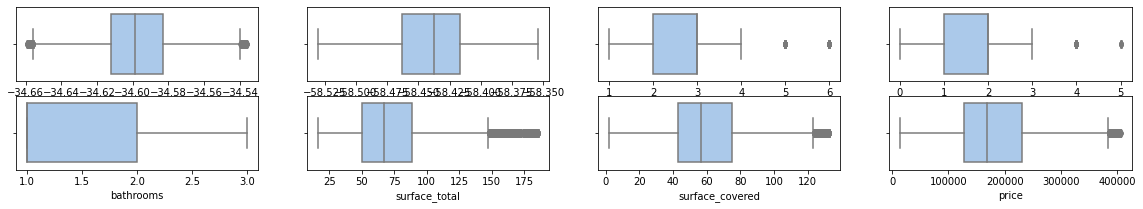

In [64]:
outliers_boxplot(work_df)

Se observa una mejoría en la distribución tras eliminar los outliers (valores atípicos).

Procedo a revisar la districución del precio.

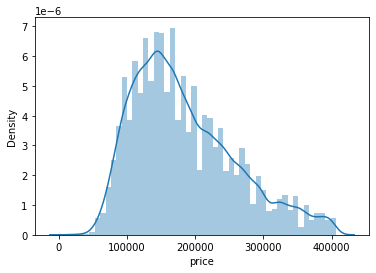

In [65]:
sns.distplot(work_df.price)

El precio indicaría estar segado a la derecha. Aunque esto puede o no reflejar la realidad de la totalidad de los inmuebles, aunque sí es probable que tenga sentido para el estudio de las ventas ya que es probable que en un periodo alto de construcción existan más propiedades nuevas publicadas y, por ende, mayor precio.

In [ ]:
work_df.price.describe()

count     45108.000000
mean     190587.343354
std       81851.662438
min       14000.000000
25%      129000.000000
50%      172000.000000
75%      239900.000000
max      439200.000000
Name: price, dtype: float64

In [ ]:
print ("Asimetría del precio {}".format(work_df.price.skew()))

Asimetría del precio 0.833684081881777


In [ ]:
np.sqrt(work_df.price).describe()

count    45108.000000
mean       426.929844
std         91.205460
min        118.321596
25%        359.165700
50%        414.728827
75%        489.795876
max        662.721661
Name: price, dtype: float64

Ahora indago un poco en las características de la variable precio, con el fin de poder comprenderla mejor:

Valor promedio del metro cuadrado:

In [ ]:
(work_df.price/work_df.surface_total).mean()

2606.1528077921944

Valor promedio de las propiedades:

In [ ]:
work_df.price.mean()

190587.34335372882

Gráfico pairplot donde podremos observar la relación de a pares entre variables, principalmente las relaciones respecto del precio.

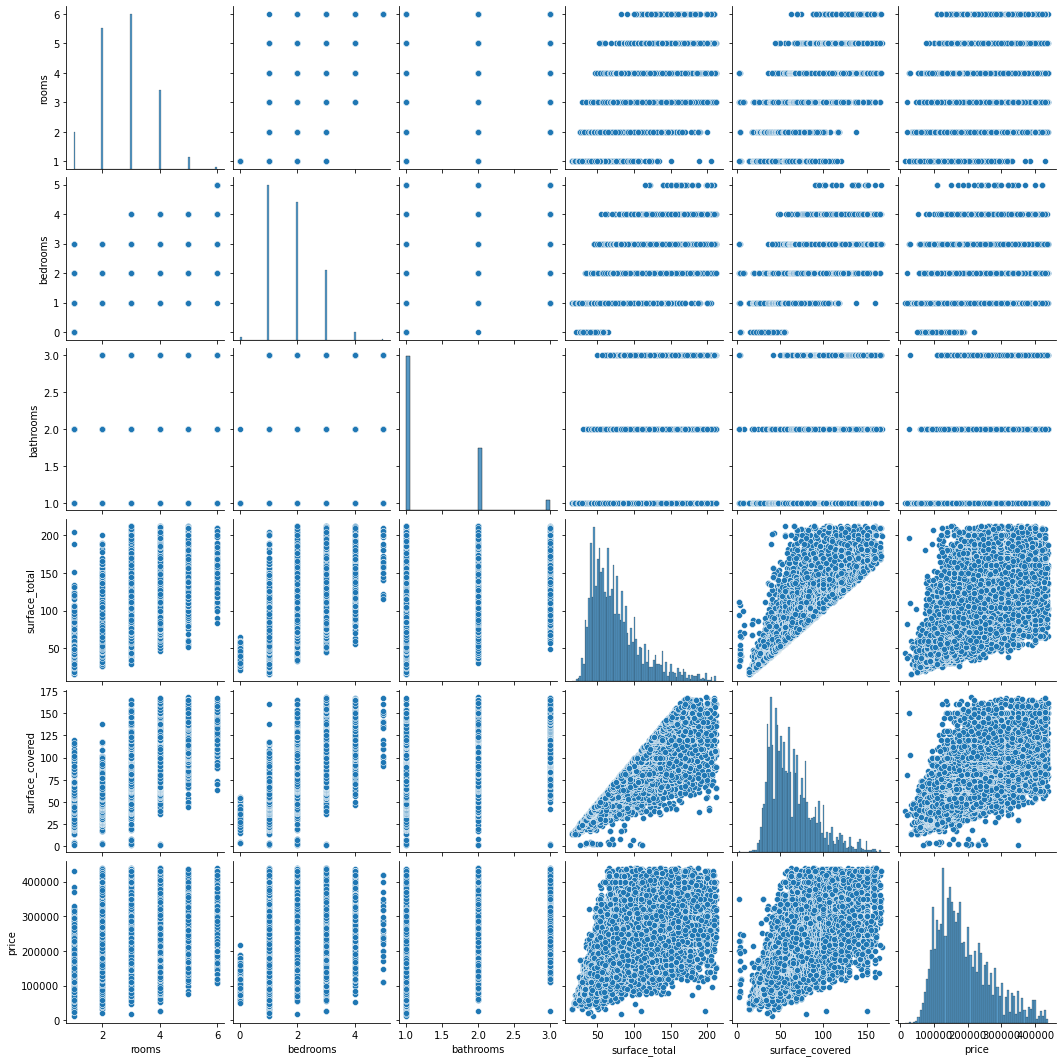

In [ ]:
sns.pairplot(data = work_df[["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "price"]], palette = 'pastel')

El gráfico de pairplot no arroja mucha información relevante, más allá de que las variables alucivas a la superficie parecieran tener cierta relación lineal (aunque con mucha varianza) con el precio. Luego, tanto rooms como bedrooms y bathrooms indican un acenso del precio mínimo a medida que aumenta la cantidad de éstos. A su vez, con rooms y bathrooms ocurre también (y en menor medida) lo inverso con los precios máximos.

###**Correlaciones:** 
Estudiaré la correlación entre las variables `rooms`, `bedrooms`, `bathrooms`, `surface_total`, `surface_covered`y `price` con el fin de poder definir cuáles de estas son las mejores variables para predecir el precio. En general y para cada tipo de propiedad.

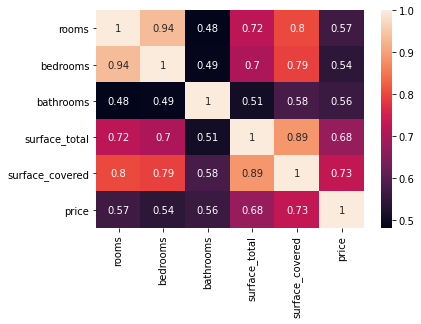

In [66]:
corrMatrix = work_df[["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "price"]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Las variables que más correlación presentan son las relacionadas a la superficie de la propiedad.

Para una mejor comprensión, voy a desglosar la matriz de correlación en tres, una por cada tipo de propiedad (Departamento, Casa y PH). Al final se comentarán las conclusiones.

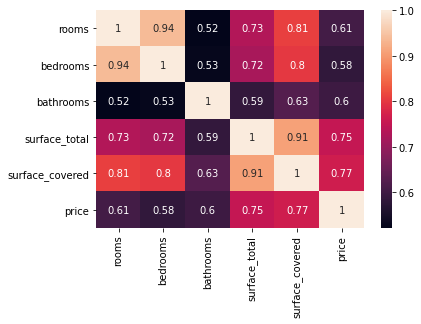

In [ ]:
Dpto_df = work_df[work_df.property_type == 'Departamento']
corrMatrix = Dpto_df[["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "price"]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

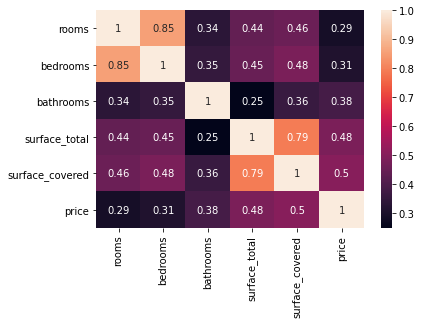

In [ ]:
Casa_df = work_df[work_df.property_type == 'Casa']
corrMatrix = Casa_df[["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "price"]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

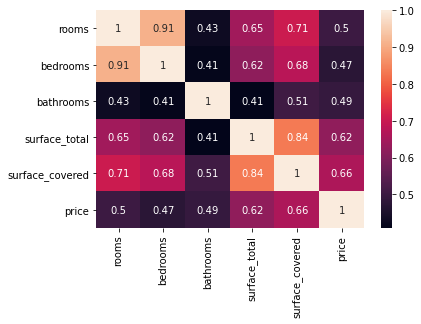

In [ ]:
PH_df = work_df[work_df.property_type == 'PH']
corrMatrix = PH_df[["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered", "price"]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

Se aprecia que la variable surface_covered es la que mayor correlación lineal presenta con la variable price. Adicionalmente, surface_covered y surface_total también presentan una fuerte correlación, por lo que surface_total puede ser redundante. Lo mismo podría suceder con esta variable respecto de bedrooms y rooms. Lo que nos deja con bathrooms como el posible segundo indicador que agregue información al análisis.

Adicionalmente, el tipo de propiedad que más fuerte correlación presenta entre las variables y el precio son los Departamentos. Luego, los PH con correlaciones inferiores a las que se obtienen en la matriz con los datos totales. En último lugar (y muy por debajo) se encuentran las casas.

### Cuáles son los cinco barrios con el promedio de valor inmueble más elevado en CABA?

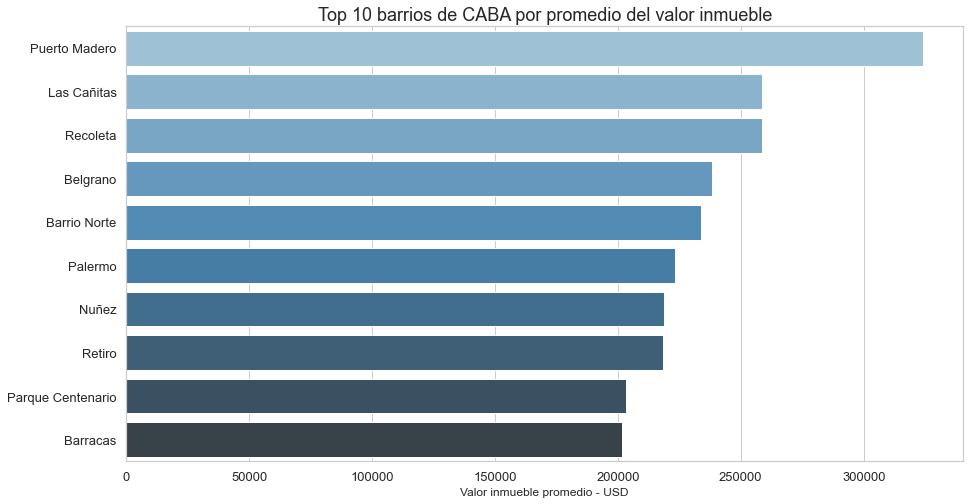

In [ ]:
means = work_df.groupby("l3")["price"].mean()
#print(means.head())
means = means.sort_values(ascending=False)

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))
sns.set_color_codes("pastel")

ax = sns.barplot(x = means[:10].values, y = means[:10].index, palette="Blues_d") 
#ax.axhline(0, color="k", clip_on=False)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
sns.set(font_scale=1.5)
plt.title("Top 10 barrios de CABA por promedio del valor inmueble")
# Add a legend and informative axis label
ax.set(ylabel="")
ax.set(xlabel="Valor inmueble promedio - USD")
ax.tick_params(labelsize=13)
#sns.despine(left=True, bottom=True)

Obtenemos que, en principio, son Puerto Madero, Las Cañitas, Recoleta, Belgrano y Barrio Norte. Pero antes de concluir es buena idea revisar la distribución de los datos en un mapa:

<AxesSubplot:xlabel='lon', ylabel='lat'>

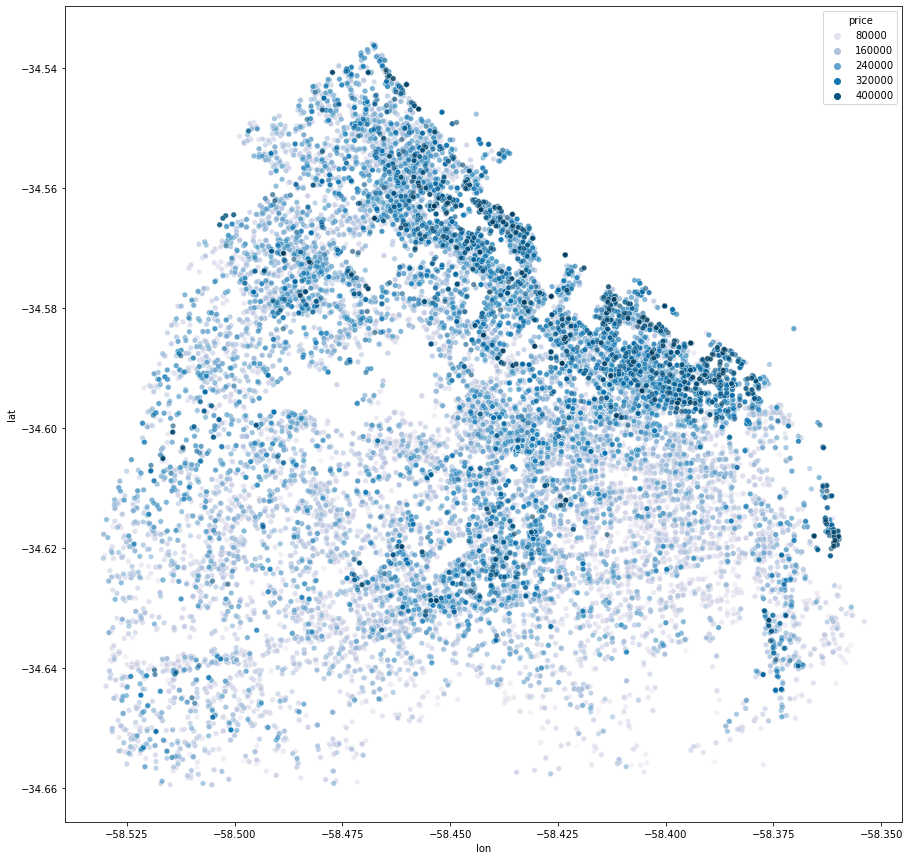

In [ ]:
var = work_df.sort_values("price",ascending=True)

x = var.lon
y = var.lat
f, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=var, x=x, y=y, s=30, hue="price", palette="PuBu", alpha=0.6) #style = "property_type",
#sns.histplot(data=var,x=x, y=y, bins=150, pthresh=.1) #cmap="dark:#69d")
#sns.kdeplot(data=var, x=x, y=y, weights="price", levels=8, color="k", linewidths=0.8)

Si bien el ranking anterior es coherente, se observa que los barrios más caros obtenidos son también los que parecieran tener mayor densidad de publicaciones. Quizás son los barrios a los que Properati mejor llega con sus servicios. Por ejemplo en la zona Sur de CABA suele haber más propiedades fabriles, posiblemente costosas y que no figuran quizás porque tienden a ser alquiladas, por lo que su cotización como bien inmueble no se encuentra publicada debido a que no suelen estar a la venta. Lo mismo podría suceder en las zonas comerciales, como en Avenida Avellaneda o el barrio de Balvanera. Asimismo son zonas con gran cantidad de parques y propiedades Estatales.

Adicionalmente, puede influir el sector de la construcción. Si existen más proyectos en los barrios de la zona norte, habrá más ventas y de inmuebles nuevos, afectando el resultado del precio promedio.

## Modelos preliminares de Machine Learning

Entrenaré dos modelos - uno de vecinos más cercanos y otro de árboles de decisión -  para predecir el precio de las propiedades tipo `Departamento`, `PH` y `Casa`  en la Ciudad Autónoma de Buenos Aires (`Capital Federal`).

Estos modelos son preliminares como punto de partida, el modelado final se desarrollará en otro notebook dentro de este mismo repositorio.

### Métrica de evaluación del modelo
Utilizaré el error cuadrático medio (MSE por sus siglas en inglés), que toma el promedio del cuadrado de la difetrencia entre los valores originales y los predichos. Esta métrica castiga a los errores altos en mayor relación que a los más pequeños. Este efecto amplificador resultará útil a la hora de seleccionar los hiperparámetros del modelo.

In [70]:
main_vars = work_df[['price','rooms','bedrooms','bathrooms','surface_total','surface_covered']].copy()

In [72]:
main_vars.head()

,price,rooms,bedrooms,bathrooms,surface_total,surface_covered
1,159000.0,2.0,1.0,2.0,70.0,58.0
3,295000.0,2.0,1.0,1.0,85.0,50.0
8,89000.0,1.0,1.0,1.0,45.0,37.0
9,89000.0,1.0,1.0,1.0,45.0,37.0
10,170000.0,2.0,1.0,2.0,66.0,49.0


In [73]:
main_vars.shape

(43296, 6)

Divido los datos en entrenamiento y prueba:

In [75]:
X_train, X_test, y_train, y_test = train_test_split(main_vars.iloc[:,[1,2,3,4,5]],main_vars.price.values, test_size=0.2, random_state=1905)

### Modelo Benchmark
Realizaré un modelo simple (en este caso una regresión lineal) para poder evaluar si con los modelos más complejos obtendré resultados efectivamente más satisfactorios, a modo de que se justifique su implementación.

In [76]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_pred,y_test)
print("MSE: ", mean_squared_error(y_pred,y_test))

MSE:  2432602063.711228


Este va a ser nuestro error base

### KNeighbors regressor:

In [77]:
mse_train = []
mse_test = []
depth = []

for i in range(1, 30):
    depth.append(i)
    regressor_knn_ingenuo = KNeighborsRegressor(n_neighbors=i, weights='uniform')
    regressor_knn_ingenuo.fit(X=X_train,y=y_train)
    
    # Predecimos sobre nuestro set de entrenamieto
    y_pred = regressor_knn_ingenuo.predict(X_train)
    # Comaparamos con las etiquetas reales
    mse_train.append(mean_squared_error(y_pred,y_train))
    
    # Predecimos sobre nuestro set de entrenamieto
    y_pred = regressor_knn_ingenuo.predict(X_test)
    # Comaparamos con las etiquetas reales
    mse_test.append(mean_squared_error(y_pred,y_test))

[Text(0, 0.5, 'MSE'), Text(0.5, 0, 'n neighbours')]

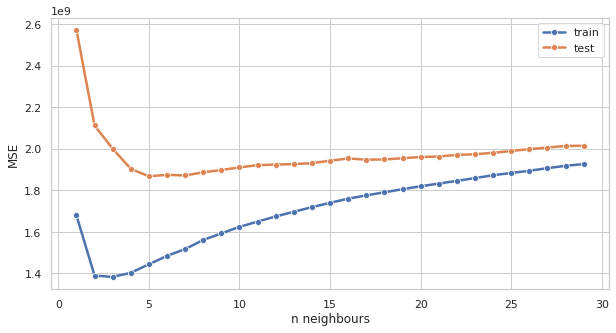

In [78]:
plt.figure(figsize = (10,5))
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x = depth, y = mse_train, palette="tab10", linewidth=2.5, label="train", marker="o")
sns.lineplot(x = depth, y = mse_test, palette="tab10", linewidth=2.5, label="test", marker="o")

ax.set(xlabel="n neighbours", ylabel = "MSE")

Selecciono nro de vecinos cercano igual a 7, ya que es el punto donde los valores previos del error en test son aproximadamente constantes antes de ascender y donde el error de train más se asemeja a estos primeros valores de test.

In [80]:
regressor_knn_ingenuo = KNeighborsRegressor(n_neighbors=7, weights='uniform')
regressor_knn_ingenuo.fit(X=X_train,y=y_train)
# Predecimos sobre nuestro set de testeo
y_pred = regressor_knn_ingenuo.predict(X_test)
# Comaparamos con las etiquetas reales
knn_mse = mean_squared_error(y_pred,y_test)
print('MSE:  ' + str(round(mean_squared_error(y_pred,y_test),2)) +'\nRMSE: ' + str(round(np.sqrt(mean_squared_error(y_pred,y_test)),2)))

MSE:  1871294958.57
RMSE: 43258.47


### Decision tree regressor:

In [81]:
mse_train = []
mse_test = []
depth = []

for i in range(1, 25):
    depth.append(i)
    regresor_dt_ingenuo = DecisionTreeRegressor(max_depth = i, random_state = 1905)
    regresor_dt_ingenuo.fit(X=X_train,y=y_train)
    
    # Predecimos sobre nuestro set de entrenamieto
    y_pred = regresor_dt_ingenuo.predict(X_train)
    # Comaparamos con las etiquetas reales
    mse_train.append((mean_squared_error(y_train,y_pred)))
    
    # Predecimos sobre nuestro set de entrenamieto
    y_pred = regresor_dt_ingenuo.predict(X_test)
    # Comaparamos con las etiquetas reales
    mse_test.append((mean_squared_error(y_test,y_pred)))

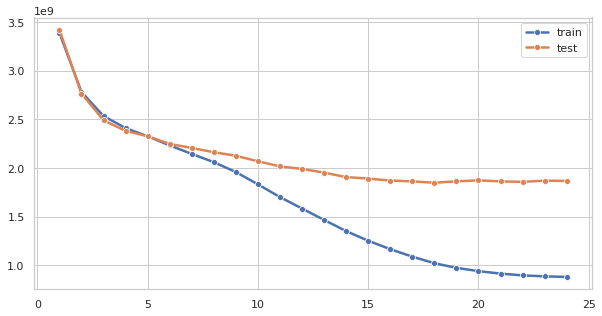

In [82]:
plt.figure(figsize = (10,5))
sns.set_theme(style="whitegrid")
sns.lineplot(x = depth, y = mse_train, palette="tab10", linewidth=2.5, label="train", marker="o")
sns.lineplot(x = depth, y = mse_test, palette="tab10", linewidth=2.5, label="test", marker="o")

Selecciono un máximo de profundidad de 7, ya que es el punto donde el error de train y test todavía se mantienen cercanos y donde las curvas comienzan a alejarse.

In [83]:
regresor_dt_ingenuo = DecisionTreeRegressor(max_depth=7, random_state = 1950)
regresor_dt_ingenuo.fit(X=X_train,y=y_train)

# Predecimos sobre nuestro set de testeo
y_pred = regresor_dt_ingenuo.predict(X_test)
# Comaparamos con las etiquetas reales
tree_mse = mean_squared_error(y_pred,y_test)
print('MSE:  ' + str(round(mean_squared_error(y_pred,y_test),2)) +'\nRMSE: ' + str(round(np.sqrt(mean_squared_error(y_pred,y_test)),2)))

MSE:  2206233287.19
RMSE: 46970.56


Modelo: Árbol de Decisión
Error cuadrático medio en Train: 2145006848.7370172
Error cuadrático medio en Test: 2206233287.1890154


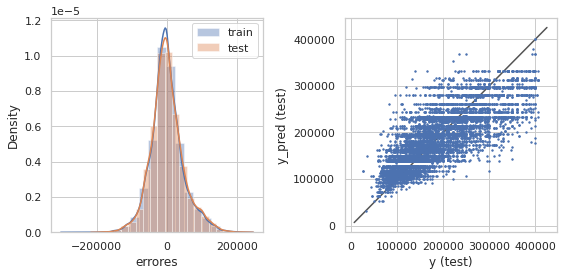

Modelo: Vecinos más cercanos
Error cuadrático medio en Train: 1517255249.5085013
Error cuadrático medio en Test: 1871294958.5722628


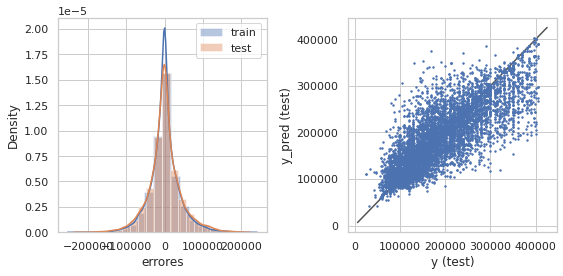

In [84]:
modelos = ['Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([regresor_dt_ingenuo, regressor_knn_ingenuo]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')

    mse_train = (mean_squared_error(y_train, y_train_pred))
    mse_test = (mean_squared_error(y_test, y_test_pred))
    print(f'Error cuadrático medio en Train: {mse_train}')
    print(f'Error cuadrático medio en Test: {mse_test}')
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

### Comparación respecto de la regresión lineal

In [85]:
knn_lr = knn_mse/lr_mse
tree_lr = tree_mse/lr_mse
print('knn_mse/lr_mse :', knn_lr, '\ntree_mse/lr_mse :', tree_lr)

knn_mse/lr_mse : 0.7692565037609878 
tree_mse/lr_mse : 0.9069437702536273


Vemos que ambos modelos presentan errores elevados. De elegir entre alguno de los modelos, optaría por utilizar el KNN, ya que es el que presenta menor error y es el que más se aleja porcentualmente (hacia abajo) del error del modelo de la simple regresión lineal. Aunque con estos resultados no utilizaría ninguno, sí se justificaría utilizar el modelo de KNN en lugar de la regresión lineal.

Recomendaría utilizar la información de latitud y longitud o, también, la de los barrios a los que pertenece cada propiedad. Mientras que superficie cubierta puede resultar redundante contando ya con la variable de superficie total. Lo mismo puede suceder entre rooms y bedrooms.

Aquí termina el análisis exploratorio de los datos. Las alternativas mencionadas serán evaluadas en siguiente notebook con desarrollo de los modelos finales.